In [23]:
# Imports

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [24]:
# Read data from file (Parquet)

# df = pd.read_parquet('dataset/reddit_scrape_20_Jan2015_timestamp.gzip')
# path = 'dataset/reddit_scrape_20_Jan2015_timestamp.gzip'
# path = '/Users/avocado/Developer/Projects/two-sentence-horror-lm/dataset/reddit_scrape_20_Jan2015_timestamp.gzip'
path = 'org_reddit_scrape_20_Jan2015_timestamp.csv'
df = pd.read_csv(path)
print("Num rows:", len(df))
df

Num rows: 107501


/var/folders/7l/ksf250vx2zn5dv30k429zj6m0000gn/T/ipykernel_64691/1734441779.py:7: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


,Unnamed: 0,title,selftext,score,num_comments,gilded_count,date,timestamp
0,0,Screaming down a well late at night is a dange...,NaN,43.0,0.0,0,1.423852e+09,2015-02-13 18:19:12
1,1,"""Do not expose any part of your body to the air.""","""I repeat..this is not a drill..""",65.0,5.0,0,1.428090e+09,2015-04-03 19:47:13
2,2,"I sometimes remember the way he looked, broken...",I neglected to make sure he was dead.,22.0,0.0,0,1.428235e+09,2015-04-05 11:55:10
3,3,I live alone on the third floor of my apartmen...,So who opens my window every night while I'm s...,35.0,3.0,0,1.428370e+09,2015-04-07 01:24:42
4,4,"I heard the rain hitting my window, so I walke...","My window wasn't wet, but the glass was covere...",28.0,3.0,0,1.428385e+09,2015-04-07 05:40:55
...,...,...,...,...,...,...,...,...
107496,107495,As I look thru at window I see something inhumane,My reflection helps me remember how well my su...,31.0,2.0,0,1.680377e+09,2023-04-01 19:21:54
107497,107496,I’ve always been passionate about conspiracy t...,"So when my wife had twins, I knew exactly what...",27.0,8.0,0,1.680377e+09,2023-04-01 19:24:55
107498,107497,"""You'll see me on the red carpet one day,"" sai...","So I paid her a surprise visit, and upon walki...",23.0,2.0,0,1.680378e+09,2023-04-01 19:38:03
107499,107498,I could hear my sister screaming nearby as I s...,But my heart sank when I remembered the monste...,60.0,3.0,0,1.680378e+09,2023-04-01 19:41:01


# Step 1: Parsing (Remove posts or text from posts containing keywords that aren't in stories)

### Things to get rid of
#### title:
- [deleted by user]
- [Announcement]
- [ANNOUNCEMENT]
- [Discussion]
- [deleted]
- [Meta]
- [UPDATE]
- [redacted]
- [Repost]
- [REPOST]
- [WP]
- [ Removed by Reddit ]
- [TW-SA]
- [TW: SA]

#### selftext:
- [removed]
- [deleted]

### Things to remove from string (not remove entire submission)
#### Title
- [MORPH]
- "[MORPH] - "
- [Morph]
- "[Morph] - "
- [morph]
- "[morph] - "
- [Metamorphosis]
- [Serious]
- [Nsfw]
- [NSFW]
- [MAY2020]
- [May 2020]
- [MAY 2020]

In [25]:
# 1. Remove any row that has an empty cell
# Replace empty strings with NaN
df.replace('', np.nan, inplace=True)

# Drop rows where any of the columns has NaN
df.dropna(inplace=True)

print(len(df))

106600


In [26]:
# 2. Remove specific tokens in titles that are associated with non-stories
bad_title_tokens = ['deleted by user', 'Announcement', 'ANNOUNCEMENT', 'Discussion', 'deleted', 'Meta', 'UPDATE', 'redacted', 'Repost', 'REPOST', 'repost', 'WP', ' Removed by Reddit ', 'TW-SA', 'TW: SA', 'META', 'MOD POST']

# Convert the list of bad title tokens to a regex pattern
pattern = r'\[\s?(' + '|'.join(map(re.escape, bad_title_tokens)) + r')\s?\]'

# Filter the DataFrame to keep rows that don't match the pattern
df = df[~df['title'].str.contains(pattern, regex=True)]

print(len(df))

105987


/var/folders/7l/ksf250vx2zn5dv30k429zj6m0000gn/T/ipykernel_64691/2441962984.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['title'].str.contains(pattern, regex=True)]


In [27]:
# 3. Remove specific tokens in self-texts that are associated with non-stories
bad_selftext_tokens = ['removed', 'deleted', 'Deleted', 'Removed', 'REDACTED', 'DELETED']

# Convert the list of bad title tokens to a regex pattern
pattern = r'\[\s?(' + '|'.join(map(re.escape, bad_selftext_tokens)) + r')\s?\]'

# Filter the DataFrame to keep rows that don't match the pattern
df = df[~df['selftext'].str.contains(pattern, regex=True)]

print(len(df))

95449


/var/folders/7l/ksf250vx2zn5dv30k429zj6m0000gn/T/ipykernel_64691/3458426278.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['selftext'].str.contains(pattern, regex=True)]


In [28]:
# 2.5. Remove specific tokens in titles that are invalid
invalid_title_tokens = ['Äù', 'Ä¶', 'Äô', 'Ä', 'ù', '¶', 'ô']

# Convert the list of bad title tokens to a regex pattern
pattern = r'\[\s?(' + '|'.join(map(re.escape, invalid_title_tokens)) + r')\s?\]'

# Filter the DataFrame to keep rows that don't match the pattern
df = df[~df['title'].str.contains(pattern, regex=True)]

print(len(df))

95449


/var/folders/7l/ksf250vx2zn5dv30k429zj6m0000gn/T/ipykernel_64691/4064981039.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['title'].str.contains(pattern, regex=True)]


In [29]:
# 3.5. Remove specific tokens in titles that are invalid
invalid_selftext_tokens = ['Äù', 'Ä¶', 'Äô', 'Ä', 'ù', '¶', 'ô']

# Convert the list of bad title tokens to a regex pattern
pattern = r'\[\s?(' + '|'.join(map(re.escape, invalid_selftext_tokens)) + r')\s?\]'

# Filter the DataFrame to keep rows that don't match the pattern
df = df[~df['selftext'].str.contains(pattern, regex=True)]

print(len(df))

95449


/var/folders/7l/ksf250vx2zn5dv30k429zj6m0000gn/T/ipykernel_64691/718862050.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['selftext'].str.contains(pattern, regex=True)]


In [30]:
# 4. Remove dates from titles

# Usually, format is: "[" + (optional space) + month (3-char) + (optional space) + "]"
df['title'] = df['title'].str.replace(r'\[[A-Za-z]{3,4}\d{2,4}\]\s?', '', regex=True)

# Extended regex to month = 7 char (for ex like AUGUST, July, etc)
df['title'] = df['title'].str.replace(r'\[[A-Za-z]{3,7}\s?\d{2,4}\]\s?', '', regex=True)

# Cases: [AUG21 ] and [JAN22 ] (notice space at end)
df['title'] = df['title'].str.replace(r'\[[A-Za-z]{3,7}\s?\d{2,4}\s?\]\s?', '', regex=True)

# Specific edge case: [May2020} or {Dec2020] (notice the bracket)
df['title'] = df['title'].str.replace(r'[\[\{][A-Za-z]{3,7}\s?\d{2,4}\s?[\]\}]\s?', '', regex=True)


# Apply to self-text as well
# Extended regex to month = 7 char (for ex like AUGUST, July, etc)
df['selftext'] = df['selftext'].str.replace(r'\[[A-Za-z]{3,7}\s?\d{2,4}\]\s?', '', regex=True)

print(len(df))

95449


In [31]:
# 5. Replace specific text with an empty string
tag_title_tokens = ['MORPH', 'Morph', 'morph', 'Metamorphosis', 'Nsfw', 'NSFW', 'Serious', 'Updated', 'RANT', 'MILD GORE WARNING', 'JUNE2020DESERT', 'JUNE2020TUNDRA', 'JUNE2020TUNDRATEAM', 'June2020Tundra', 'Body Horror']

# Convert the list of bad title tokens to a regex pattern
pattern = r'\[\s?(' + '|'.join(map(re.escape, tag_title_tokens)) + r')\s?\]'

# Use the pattern to replace the matched substrings with an empty string
df['title'] = df['title'].str.replace(pattern, '', regex=True)

print(len(df))

95449


In [32]:
# 6. Some titles begin with "[" + 1-3 digit number + "]", we need to replace that with an empty string
df['title'] = df['title'].str.replace(r'\[\s?\d{1,3}\s?\]\s?', '', regex=True)

print(len(df))

95449


In [33]:
# 7. Remove any titles or self-texts that contain "http" as the LM cannot watch and understand videos
# 8. Also remove any reference to r/twosentencehorror (needs to learn the concept, meta reference)

df = df[~(df['title'].str.contains('http', case=False) | df['selftext'].str.contains('http', case=False))]
df = df[~(df['title'].str.contains('https', case=False) | df['selftext'].str.contains('https', case=False))]
df = df[~(df['title'].str.contains('www', case=False) | df['selftext'].str.contains('www', case=False))]
df = df[~(df['title'].str.contains('twosentencehorror', case=False) | df['selftext'].str.contains('twosentencehorror', case=False))]

print(len(df))

95261


In [34]:
# 9. Remove any title or selftext beginning with "="

df = df[~(df['title'].str.contains('^=', case=False) | df['selftext'].str.contains('^=', case=False))]
print(len(df))

95261


# Step 2: Cleanse Data of invalid values (NaN)

In [35]:
# Remove NaN values
df = df.dropna()

# Create a boolean mask for rows to keep
# Text contains "&amp;#x200B;" which is a zero-width space (tokenized incorrectly)
mask = ~(
    df['title'].str.contains('x200B|&amp;#x200B;', na=False) |
    df['selftext'].str.contains('x200B|&amp;#x200B;', na=False)
)

# Apply the mask to filter the DataFrame
df = df[mask]


# Step 3: Optimize Data
#### The average

In [36]:
# Calculate Sequence Length

token_lengths_title = df['title'].apply(lambda x: len(x.split()))
token_lengths_selftext = df['selftext'].apply(lambda x: len(x.split()))


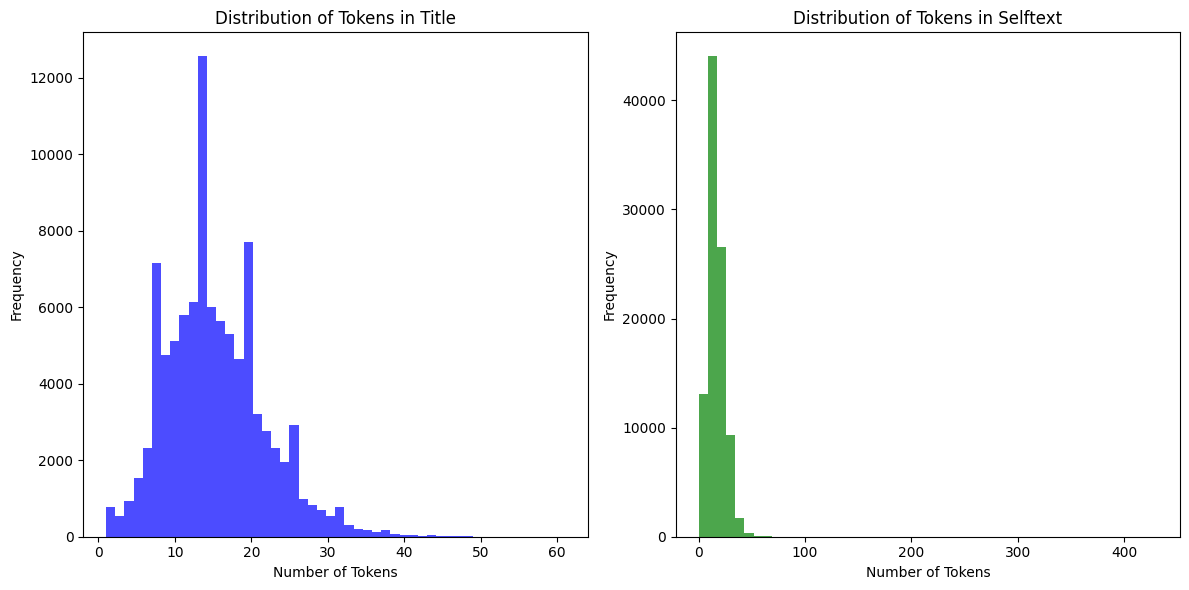

In [37]:
# Plotting

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(token_lengths_title, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Tokens in Title')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(token_lengths_selftext, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Tokens in Selftext')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [38]:
# 40 tokens looks like a good cut-off amount for the number of tokens we should keep.
# Very few posts have more than 40 tokens in either the title or selftext.
# We can greatly reduce the amount of padding necessary as a result, and hopefully speed up training time.

In [43]:
cut_off = 40

In [44]:
# Find rows where both title and selftext are below 100 tokens
below_cut_off_tokens = df[(token_lengths_title < cut_off) & (token_lengths_selftext < cut_off)]

# Calculate the percentage
percentage_below_cut_off = (len(below_cut_off_tokens) / len(df)) * 100

print(f"Percentage of data with both title and selftext below 40 tokens: {percentage_below_cut_off:.2f}%")


Percentage of data with both title and selftext below 40 tokens: 99.76%


In [19]:
print("Full DF Size:", len(df))
print(f"DF Size below {cut_off} tokens:", len(below_cut_off_tokens))

Full DF Size: 95204
DF Size below 40 tokens: 94086


In [20]:
# Drop "Unnamed: 0" column (index column before removing posts below cut_off tokens)

below_cut_off_tokens.drop(columns=['Unnamed: 0'], inplace=True)
below_cut_off_tokens.reset_index(drop=True, inplace=True)

/var/folders/7l/ksf250vx2zn5dv30k429zj6m0000gn/T/ipykernel_64691/1366232947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  below_cut_off_tokens.drop(columns=['Unnamed: 0'], inplace=True)


In [21]:
below_cut_off_tokens

,title,selftext,score,num_comments,gilded_count,date,timestamp
0,"""Do not expose any part of your body to the air.""","""I repeat..this is not a drill..""",65.0,5.0,0,1.428090e+09,2015-04-03 19:47:13
1,"I sometimes remember the way he looked, broken...",I neglected to make sure he was dead.,22.0,0.0,0,1.428235e+09,2015-04-05 11:55:10
2,I live alone on the third floor of my apartmen...,So who opens my window every night while I'm s...,35.0,3.0,0,1.428370e+09,2015-04-07 01:24:42
3,"I heard the rain hitting my window, so I walke...","My window wasn't wet, but the glass was covere...",28.0,3.0,0,1.428385e+09,2015-04-07 05:40:55
4,You know how sometimes your brain plays tricks...,I caught one of those things today.,84.0,6.0,0,1.428563e+09,2015-04-09 07:03:16
...,...,...,...,...,...,...,...
94081,As I look thru at window I see something inhumane,My reflection helps me remember how well my su...,31.0,2.0,0,1.680377e+09,2023-04-01 19:21:54
94082,I’ve always been passionate about conspiracy t...,"So when my wife had twins, I knew exactly what...",27.0,8.0,0,1.680377e+09,2023-04-01 19:24:55
94083,"""You'll see me on the red carpet one day,"" sai...","So I paid her a surprise visit, and upon walki...",23.0,2.0,0,1.680378e+09,2023-04-01 19:38:03
94084,I could hear my sister screaming nearby as I s...,But my heart sank when I remembered the monste...,60.0,3.0,0,1.680378e+09,2023-04-01 19:41:01


In [22]:
# below_cut_off_tokens.to_csv(f'reddit_cleansed_data.csv', index=False)